# Padaria Portugesa Geolocation

In [547]:
# classic import
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gp
import matplotlib.pyplot as plt
import warnings
import sys
import matplotlib as mpl
warnings.simplefilter('ignore')

# import local functions
path_to_functions = 'C:/Users/Zaca/Documents/GitHub/useful-functions/'
sys.path.append(path_to_functions)
from plotting import default_plot, get_colors

In [548]:
# matplotlib formatting
small = 10
medium = 12
large = 14

plt.rc('font', size=small)         # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', labelsize=small)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)   # fontsize of the tick labels
plt.rc('ytick', labelsize=small)   # fontsize of the tick labels
plt.rc('legend', fontsize=small)   # legend fontsize
plt.rc('figure', titlesize=large)   # fontsize of the figure title
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

In [549]:
# open data
freguesias = gp.read_file('data/freguesias.shp')
padarias = pd.read_csv('data/padarias.csv', index_col=0)
population = pd.read_csv('data/populacao-freguesias.csv', sep=';', engine='python', header=None, usecols=[1, 3, 4], names=['CODIGO','NOME', 'POP'])
population = population[(population['CODIGO'] == "'1106'") & (population['NOME'] != 'Lisboa')].reset_index()

# there were two duplicated restaurants in the same location
padarias.drop_duplicates(subset='restaurant.name', inplace=True)

In [550]:
# change projection to 2D in meters
freguesias = freguesias.to_crs('EPSG:3763')

In [551]:
# transform Zomato data into GeoDataFrame
padarias = gp.GeoDataFrame(padarias, geometry=gp.points_from_xy(padarias['restaurant.location.longitude'], padarias['restaurant.location.latitude']))

# transform from naive coordinates to the actual CRS system they are in.
padarias.crs = {'init' :'epsg:4326'}

# re-project to the same as the Lisbon map
padarias = padarias.to_crs('EPSG:3763')

In [552]:
# remove points outside the city
padarias = padarias[padarias.geometry.within(freguesias.unary_union)]

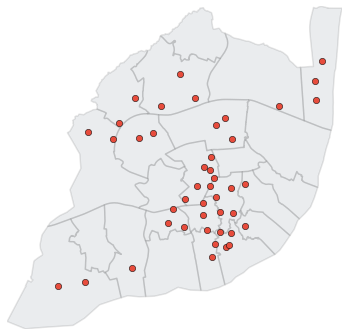

In [570]:
# plot base map and restaurant locations
base = freguesias.plot(figsize=(6, 6), facecolor='#34495e', edgecolor='black', linewidth= 1.5, alpha=.1)
padarias.plot(ax=base, marker='o', color='#e74c3c', markersize=40, edgecolor='k', linewidth=.5)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
#plt.savefig('figures/basemap_locations.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [554]:
circles = padarias.buffer(500)

In [555]:
intersection = circles.unary_union.intersection(freguesias.unary_union)

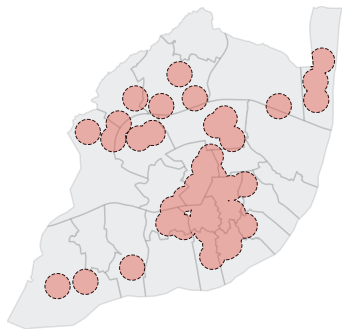

In [556]:
base = freguesias.plot(figsize=(6, 6), facecolor='#34495e', edgecolor='black', linewidth= 1.5, alpha=.1)
gp.GeoSeries(intersection).plot(ax=base, facecolor='none', edgecolor='k', lw=1, ls='dashed')
gp.GeoSeries(intersection).plot(ax=base, facecolor='#e74c3c', alpha=.4)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig('figures/area_difference.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [557]:
intersection = circles.unary_union.intersection(freguesias.unary_union)
area_covered = intersection.area/freguesias.unary_union.area
print(area_covered)

0.2504503331872856


In [558]:
intersections_all = freguesias['geometry'].intersection(circles.unary_union)

In [559]:
freguesias['area_covered'] = intersections_all.area/freguesias.area

In [584]:
pop_map = pd.Series(population.POP.values, index=population.NOME).to_dict()
freguesias['POP'] = freguesias['NOME'].map(pop_map)
freguesias['population_reached'] = freguesias['POP'] * freguesias['area_covered']
freguesias.sort_values(by='population_reached', ascending=True, inplace=True)
freguesias['colors'] = get_colors('viridis', freguesias.shape[0], plot=False)

['Beato', 'Santa Clara', 'Ajuda', 'Estrela', 'Marvila', 'Alcântara', 'Olivais', 'Belém', 'Campolide', 'Areeiro', 'São Vicente', 'Santa Maria Maior', 'Carnide', 'Penha de França', 'Misericórdia', 'Benfica', 'Parque das Nações', 'Santo António', 'Alvalade', 'São Domingos de Benfica', 'Avenidas Novas', 'Campo de Ourique', 'Lumiar', 'Arroios']


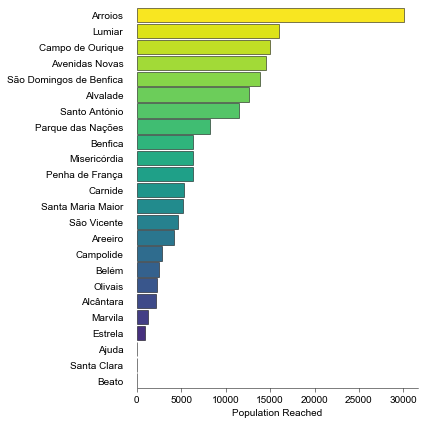

In [585]:
def categorical_bar(data, rotation=0, name='figures/default_categorical_bar', save=False):
    
    # makes a categorical bar plot
    # input data has to be a dataframe with 3 columns
    # column 0 contains the labels that go on the x-axis (already pre-formatted)
    # column 1 contains the values
    # column 2 contains the colors
    # the title of the value-columns contains the label for the Y-axis
    # the name variable should contain path and filename to save to file

    size_dict = {4:4,
                 17:8}
    
    labels = [str(i+1) + list(data[data.columns[0]])
    values = list(data[data.columns[1]])
    
    print(labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax = default_plot(ax, ['left'])
    x = range(len(values))
    
    ax.yaxis.set_tick_params(length=0)
    ax.spines['left'].set_visible(False)
    
    plt.ylim(-0.45, len(values) - 0.45)
    #plt.xlim(0, 1)

    xlabel = data.columns[1].replace('_',' ').title()
    ylabel = data.columns[0].replace('_',' ').title()

    plt.xlabel(xlabel)
    plt.yticks(x, labels)
    #plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.barh(x, values, height=.9, color=data.colors, edgecolor='k', lw=.5)
    
    if save:
        plt.tight_layout()
        plt.savefig(name + '.png', dpi=100)
    
    plt.show()

categorical_bar(freguesias[['NOME', 'population_reached', 'colors']], save=True)

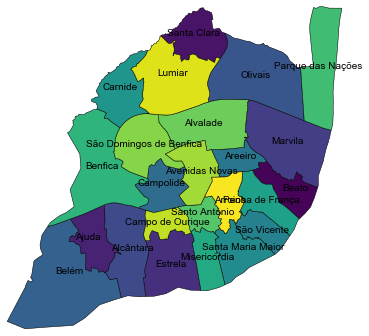

In [580]:
freguesias['coords'] = freguesias['geometry'].apply(lambda x: x.representative_point().coords[:])
freguesias['coords'] = [coords[0] for coords in freguesias['coords']]

base = freguesias.plot(figsize=(6, 6), facecolor=freguesias['colors'], edgecolor='black', linewidth= .5, alpha=1)
for idx, row in freguesias.iterrows():
    plt.annotate(s=row['NOME'], xy=row['coords'],
                 horizontalalignment='center')

    #padarias.plot(ax=base, marker='o', color='#e74c3c', markersize=40, edgecolor='k', linewidth=.5, alpha=1)
base.axis('off');
base.margins(0)
base.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [ ]:
freguesias['people_count'].sum()/freguesias['POP'].sum()

In [ ]:
# Compare with metro

In [ ]:
metro = gp.read_file('data/metro-lisboa.geojson')
metro = metro.to_crs('EPSG:3763')

In [ ]:
base = freguesias.plot(facecolor='none', edgecolor='k')
metro_raw.plot(ax=base)

In [ ]:
metro_circles = metro_raw.buffer(500)

In [ ]:
intersection = freguesias.unary_union.intersection(metro_circles.unary_union)
area_covered = intersection.area/freguesias.unary_union.area

In [ ]:
area_covered